## Imports

In [9]:
import requests
from requests import Session
from bs4 import BeautifulSoup
from multiprocessing import Pool, get_context
import multiprocessing
import re
import pandas as pd
import json

## Helper Functions

In [ ]:
def get_soup(url: str, headers: dict[str:str], session: Session, page_number: int):
    response = session.get(url, headers= headers)
    if page_number != None:
        print(f"Request for page {page_number} - response : {response.status_code}")
    else:
        print(f"Solving compound listing - Getting individual url")
    content = response.content
    soup = BeautifulSoup(content, 'html.parser')
    return soup

## Getting the URLS

In [ ]:
def get_url_list(num_pages: int, headers: dict[str:str], session: Session) -> list[str]:

    url_list = []

    with open('url.txt', 'w') as f:
        for page_number in (range(num_pages) + 1):
            base_url = f'https://www.immoweb.be/en/search/house-and-apartment/for-sale?countries=BE&isALifeAnnuitySale=false&page={page_number}&orderBy=relevance'
            
            try:
                soup = get_soup(base_url, headers, session, page_number)

                listings = soup.find_all("div", attrs={"class": "card--result__body"})
                
                for listing in listings:
                    for link in listing.find_all("a", attrs={"class": "card__title-link"}):
                        href = link.get("href")
                        if href:
                                url_list.append(href)
                                f.write(href +"\n")
                        else:
                                print(f"not found link {link}")

            except Exception as e:
                print(f"Error occurred on page {page_number + 1}: {e}")

    return url_list

In [4]:
def quick_get_urls(num_pages:int, headers: dict[str:str], session: Session) -> list[str]:
    ctx = get_context("spawn")
    with ctx.Pool(processes=10) as pool:
        results = pool.starmap(get_url_list, [(num_pages, headers, session)])

    url_list = []
    for page_urls in results:
        url_list.extend(page_urls)

    print(len(url_list))
    return url_list

## Getting the details from the listings

In [ ]:
def get_dict_from_url(url: str, headers: dict[str:str], session: Session, line_number: int) -> dict:

    soup = get_soup(url, headers, session, line_number)

    # Parse the content to find the <script> tag containing "window.classified"
    script_tag = soup.find('script', string=re.compile(r'window\.classified\s*='))

    if script_tag:
        print(f"Got script_tag for {url}")
        # Extract the JSON part from the script content
        match = re.search(r'window\.classified\s*=\s*(\{.*?\});', script_tag.string)
        if match:
            classified_data = match.group(1)
            # Parse the JSON data
            classified_dict = json.loads(classified_data)

            return classified_dict

        else:
            print(f"JSON data not found within the script tag for {url}.")
    else:
        print(f"Script tag with 'window.classified' not found for {url}.")

In [29]:
def is_compound_sale(classified_dict: dict) -> bool:
    return classified_dict['cluster'] != None

In [30]:
def get_compound_sale_urls(soup: str) -> list[str]:
    ...
    # Write function to get URLs of individual listings on the compound sale using the soup
    # also pass the dict created ; look at 'cluster', is units : [{type:commercial, ...}, {type:apartment, ..., items:[{id:xxxxx}]}]
    # use id numbers and if sold information to search all a tags where href contains the id number
    # concat all urls to list

In [ ]:
def read_parse_listings(url_file_path: str, headers: dict[str:str], session: Session) -> list[dict]:

    result = []
    compound_urls = []
    individual_urls = []

    with open(url_file_path, 'r') as file:
        for line_number, line in enumerate(file, start= 1):
            url = line.strip()

            listing_dict = get_dict_from_url(url, headers, session, line_number)

            if is_compound_sale(listing_dict):
                print(f"Solving compound listing for {url}")
                compound_urls.append(url + "\n")
                soup = get_soup(url, headers, session, None)
                individual_listings = get_compound_sale_urls(soup, listing_dict)
                for listing_url in individual_listings:
                    individual_urls.append(listing_url + "\n")
                    individual_dict = get_dict_from_url(listing_url, headers, session, None)
                    result.append(individual_dict)

            else:
                result.append(listing_dict)

    with open(url_file_path, "r") as f:
        lines = f.readlines()
    with open(url_file_path, "w") as f:
        for line in lines:
            if line not in compound_urls:
                f.write(line)
    with open(url_file_path, "a") as f:
        for line in individual_urls:
            f.write(line)

    return result

## Get the info from the list of dicts

In [32]:
def get_relevant_info(list_dicts_listings: list[dict]) -> list[dict]:
    for listing in list_dicts_listings:
        pass
    #write relevant code to extract the particular information needed from the listing dicts
    #place into new dict containing only relevant information
    #def get_empty_data():
    #data = {'locality':None,
     #       'property_type':None,
      #      'property_subtype':None,
       #     'price':None,
        #    'sale_type':None,
        #    'rooms':None,
        #    'area_living':None,
        #    'equipped_kitchen':None,
        #    'furnished':None,
        #    'fire':None,
        #    'terrace':None,
        #    'terrace_area':None,
        #    'garden':None,
        #    'garden_area':None,
        #    'land_surface':None,
        #    'plot_surface':None,
        #    'number_facade':None,
        #    'swimming_pool':None,
        #    'building_state':None,
        #    'immoweb_code': None}
    
    #return data

## Parse result to pd.DataFrame

In [ ]:
def parse_listing_info(relevant_info_dicts: list[dict]) -> pd.DataFrame:
    df = pd.DataFrame(relevant_info_dicts)
    df.to_csv('Immoweb_scraping_result.csv', index= False, header= True)
    return df

## Main

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',} 
number_pages = 333
session = requests.Session()
# Get listing URLs
quick_get_urls(number_pages, headers, session)

    #get_url_list(headers, session)

    # Get listings details, only relevant info

dict_list = read_parse_listings("url.txt", headers, session)

result_list = get_relevant_info(dict_list)


    # Parse to pd.DataFrame
    df = parse_listing_info(result_list)
    df.to_csv('ImmowebScrapingResult.csv')

## Testing section

#### Getting listing urls from the search pages - check

In [10]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',} 
number_pages = 20
session = requests.Session()
# Get listing URLs
get_url_list(number_pages, headers, session)

Request for page 1 - response : 200
Request for page 2 - response : 200
Request for page 3 - response : 200
Request for page 4 - response : 200
Request for page 5 - response : 200
Request for page 6 - response : 200
Request for page 7 - response : 200
Request for page 8 - response : 200
Request for page 9 - response : 200
Request for page 10 - response : 200
Request for page 11 - response : 200
Request for page 12 - response : 200
Request for page 13 - response : 200
Request for page 14 - response : 200
Request for page 15 - response : 200
Request for page 16 - response : 200
Request for page 17 - response : 200
Request for page 18 - response : 200
Request for page 19 - response : 200
Request for page 20 - response : 200


['https://www.immoweb.be/en/classified/house/for-sale/wetteren/9230/20316344',
 'https://www.immoweb.be/en/classified/apartment/for-sale/borgerhout/2140/20317800',
 'https://www.immoweb.be/en/classified/apartment/for-sale/uccle/1180/20315652',
 'https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/deinze/9800/20316163',
 'https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/gent/9000/20317711',
 'https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/gent/9000/20317701',
 'https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/gent/9000/20317700',
 'https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/gent-sint-denijs-westrem/9051/20317686',
 'https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/sint-denijs-westrem/9051/20315271',
 'https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/anderlecht/1

#### Multiprocessing - no

#### Getting info from the listed urls, and parsing to dicts

In [11]:
result = []

with open('url.txt', 'r') as file:
    for line in file:
        url = file.readline().strip()
        listing_dict = get_dict_from_url(url, headers, session)
        result.append(listing_dict)
        print(f"Got dict for {url}")

Got script_tag for https://www.immoweb.be/en/classified/apartment/for-sale/borgerhout/2140/20317800
Got dict for https://www.immoweb.be/en/classified/apartment/for-sale/borgerhout/2140/20317800
Got script_tag for https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/deinze/9800/20316163
Got dict for https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/deinze/9800/20316163
Got script_tag for https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/gent/9000/20317701
Got dict for https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/gent/9000/20317701
Got script_tag for https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/gent-sint-denijs-westrem/9051/20317686
Got dict for https://www.immoweb.be/en/classified/new-real-estate-project-apartments/for-sale/gent-sint-denijs-westrem/9051/20317686
Got script_tag for https://www.immoweb.be/en/classified/new-real-e

In [13]:
result[0]

{'id': 20317800,
 'cluster': None,
 'customers': [{'id': 3949427,
   'type': 'AGENCY',
   'email': 'bolt@omniwebsites.be',
   'logoUrl': 'https://media.immowebstatic.be/customers/001P600000Be9xXIAR/logo/5884a4a1988aba961a83b0c0d607d11e.jpg',
   'phoneNumber': '+32035686806',
   'mobileNumber': None,
   'name': 'Bolt Immo Wilrijk',
   'website': 'https://www.bolt.immo/nl/',
   'location': {'country': 'Belgium',
    'region': None,
    'province': 'Antwerp',
    'district': 'Antwerp',
    'locality': 'Wilrijk',
    'postalCode': '2610',
    'street': 'Kern 15-16',
    'number': None,
    'box': None,
    'propertyName': None,
    'floor': None,
    'latitude': 51.1710931,
    'longitude': 4.3938383,
    'distance': None,
    'approximated': None,
    'regionCode': None,
    'type': None,
    'hasSeaView': None,
    'pointsOfInterest': None,
    'placeName': None},
   'ipiNo': '503141',
   'isOwner': True,
   'contactHoursMobile': None,
   'contactHoursLandline': None,
   'salesRepresenta

In [22]:
classified_dict.keys()

dict_keys(['id', 'cluster', 'customers', 'premiumProjectPage', 'flags', 'media', 'property', 'publication', 'transaction', 'priceType', 'price', 'externalReference', 'isBookmarked', 'hasSectionsArray', 'unitGroupings', 'displayFlags', 'statistics'])

In [33]:
classified_dict['cluster']

{'minPrice': 132500,
 'maxPrice': 244500,
 'minSurface': 68,
 'maxSurface': 131,
 'projectInfo': {'constructor': None,
  'groupId': 20315407,
  'phase': None,
  'projectName': 'Hélécine - Résidence Basile',
  'deliveryDate': None,
  'soldPercentage': 50,
  'unitsDisplayMode': 'DETAILED'},
 'units': [{'type': 'COMMERCIAL',
   'maxPrice': 187500,
   'minPrice': 132500,
   'minRoom': None,
   'maxRoom': None,
   'minSurface': 94,
   'maxSurface': 131,
   'soldCount': 0,
   'items': [{'id': 20315461,
     'subtype': 'BUSINESS',
     'saleStatus': 'AVAILABLE',
     'floor': 0,
     'price': 132500,
     'bedroomCount': None,
     'realEstateProjectPhase': None,
     'surface': 94},
    {'id': 20315467,
     'subtype': 'BUSINESS',
     'saleStatus': 'AVAILABLE',
     'floor': 0,
     'price': 187500,
     'bedroomCount': None,
     'realEstateProjectPhase': None,
     'surface': 131}],
   'minPriceVAT': None,
   'maxPriceVAT': None},
  {'type': 'APARTMENT',
   'maxPrice': 244500,
   'minPric

In [44]:
def get_soup(url: str, headers: dict[str:str], session: Session, page_number: int):
    response = session.get(url, headers= headers)
    print(f"Request for page {page_number + 1} - response : {response.status_code}")
    content = response.content
    soup = BeautifulSoup(content, 'html.parser')
    return soup

In [1]:
import pandas as pd
import json

with open("relevant_dicts.json", "r") as file:
    data = json.load(file)

df = pd.DataFrame(data)

In [3]:
df.head(30)

,id,Locality,Type of property,Subtype of property,Price,Type of sale,Number of rooms,Living Area,Fully equipped kitchen,Furnished,Fireplace,Terrace,Terrace area,Garden,Garden area,Surface of the land,Surface area of the plot of land,Number of facades,Swimming pool,State of the building
0,20320744,1150,APARTMENT,APARTMENT,575000,residential_sale,3,160.0,1.0,0.0,0,1.0,40.0,1.0,290.0,290.0,NaN,NaN,0.0,GOOD
1,20317718,9000,APARTMENT,APARTMENT,390000,residential_sale,3,96.0,1.0,0.0,0,1.0,29.0,NaN,NaN,NaN,NaN,2.0,0.0,AS_NEW
2,20315842,9051,APARTMENT,APARTMENT,260000,residential_sale,1,76.0,1.0,0.0,0,1.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,GOOD
3,20315799,9051,APARTMENT,APARTMENT,325000,residential_sale,1,81.0,1.0,0.0,0,1.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,GOOD
4,20315776,9051,APARTMENT,APARTMENT,365000,residential_sale,3,101.0,1.0,0.0,0,1.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,GOOD
5,20315874,9051,APARTMENT,APARTMENT,400000,residential_sale,3,111.0,1.0,0.0,0,1.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,GOOD
6,20318337,1070,APARTMENT,PENTHOUSE,351500,residential_sale,1,83.0,1.0,0.0,0,1.0,26.0,1.0,26.0,26.0,NaN,2.0,0.0,AS_NEW
7,20318338,1070,APARTMENT,PENTHOUSE,426500,residential_sale,3,113.0,1.0,0.0,0,1.0,28.0,1.0,24.0,24.0,NaN,2.0,0.0,AS_NEW
8,20317581,9940,APARTMENT,GROUND_FLOOR,360000,residential_sale,2,103.0,1.0,0.0,0,1.0,36.0,NaN,NaN,NaN,NaN,2.0,0.0,AS_NEW
9,20317589,9940,APARTMENT,PENTHOUSE,445000,residential_sale,2,122.0,1.0,0.0,0,1.0,48.0,NaN,NaN,NaN,NaN,2.0,0.0,AS_NEW


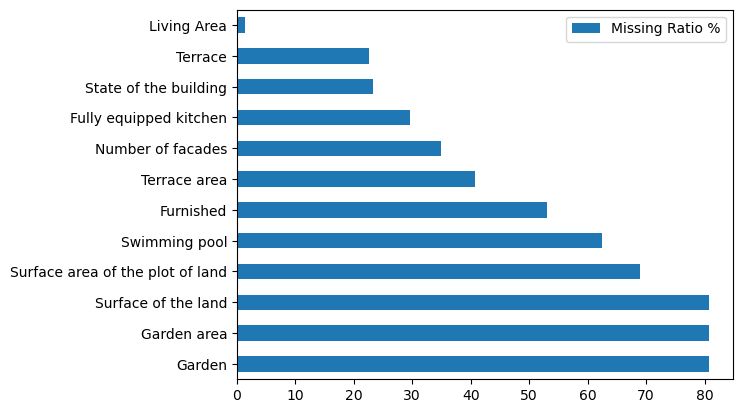

In [6]:
import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)

In [7]:
df = pd.read_csv("./ImmoWebScraper/Data/Immoweb_scraping_result.csv")

In [9]:
df.head()

,id,Locality,Type of property,Subtype of property,Price,Type of sale,Number of rooms,Living Area,Fully equipped kitchen,Furnished,...,Terrace,Terrace area,Garden,Garden area,Surface of the land,Surface area of the plot of land,Number of facades,Swimming pool,State of the building,Compound Listing
0,20320744,1150,APARTMENT,APARTMENT,575000,residential_sale,3,160.0,1.0,0.0,...,1.0,40.0,1.0,290.0,290.0,NaN,NaN,0.0,GOOD,single
1,20317718,9000,APARTMENT,APARTMENT,390000,residential_sale,3,96.0,1.0,0.0,...,1.0,29.0,NaN,NaN,NaN,NaN,2.0,0.0,AS_NEW,compound
2,20315842,9051,APARTMENT,APARTMENT,260000,residential_sale,1,76.0,1.0,0.0,...,1.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,GOOD,compound
3,20315799,9051,APARTMENT,APARTMENT,325000,residential_sale,1,81.0,1.0,0.0,...,1.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,GOOD,compound
4,20315776,9051,APARTMENT,APARTMENT,365000,residential_sale,3,101.0,1.0,0.0,...,1.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,GOOD,compound
